## MJO frequencies
In this tutorial, we show how dominant mode of 30-60 days is identified that characterizes the Madden-Julian Oscillation in the Indo-Pacific domain

In [3]:
# load libraries and files
import xarray as xr
import numpy as np
import geoutils.utils.file_utils as fut
import geoutils.utils.general_utils as gut
import geoutils.utils.statistic_utils as sut
import geoutils.utils.spatial_utils as sput
import geoutils.utils.time_utils as tu
import geoutils.tsa.time_series_analysis as tsa
import geoutils.tsa.fft_analysis as fta
import geoutils.geodata.base_dataset as bds
import geoutils.plotting.plots as cplt
import geoutils.indices.rmm_index as rmm
from importlib import reload

data_dir = "/home/strnad/data/"
plot_dir = "/home/strnad/data/plots/tutorials/mjo/"

In [4]:
# Load the data files
# z200
reload(bds)
grid_step = 2.5
dataset_file = data_dir + \
    f"/climate_data/{grid_step}/era5_ttr_{grid_step}_ds.nc"

ds_olr = bds.BaseDataset(data_nc=dataset_file,
                         can=True,
                         # compute the anomalies wrt JJAS, month and dayofyear
                         an_types=['month', 'dayofyear'],
                         verbose=False,
                         )

Rename top net thermal radiation (ttr) to: olr [W/m2]!
Multiply by -1/3600!
Created monthly anomalies!
Rename olr to olr_an_month!
Created dayofyearly anomalies!
Rename olr to olr_an_dayofyear!


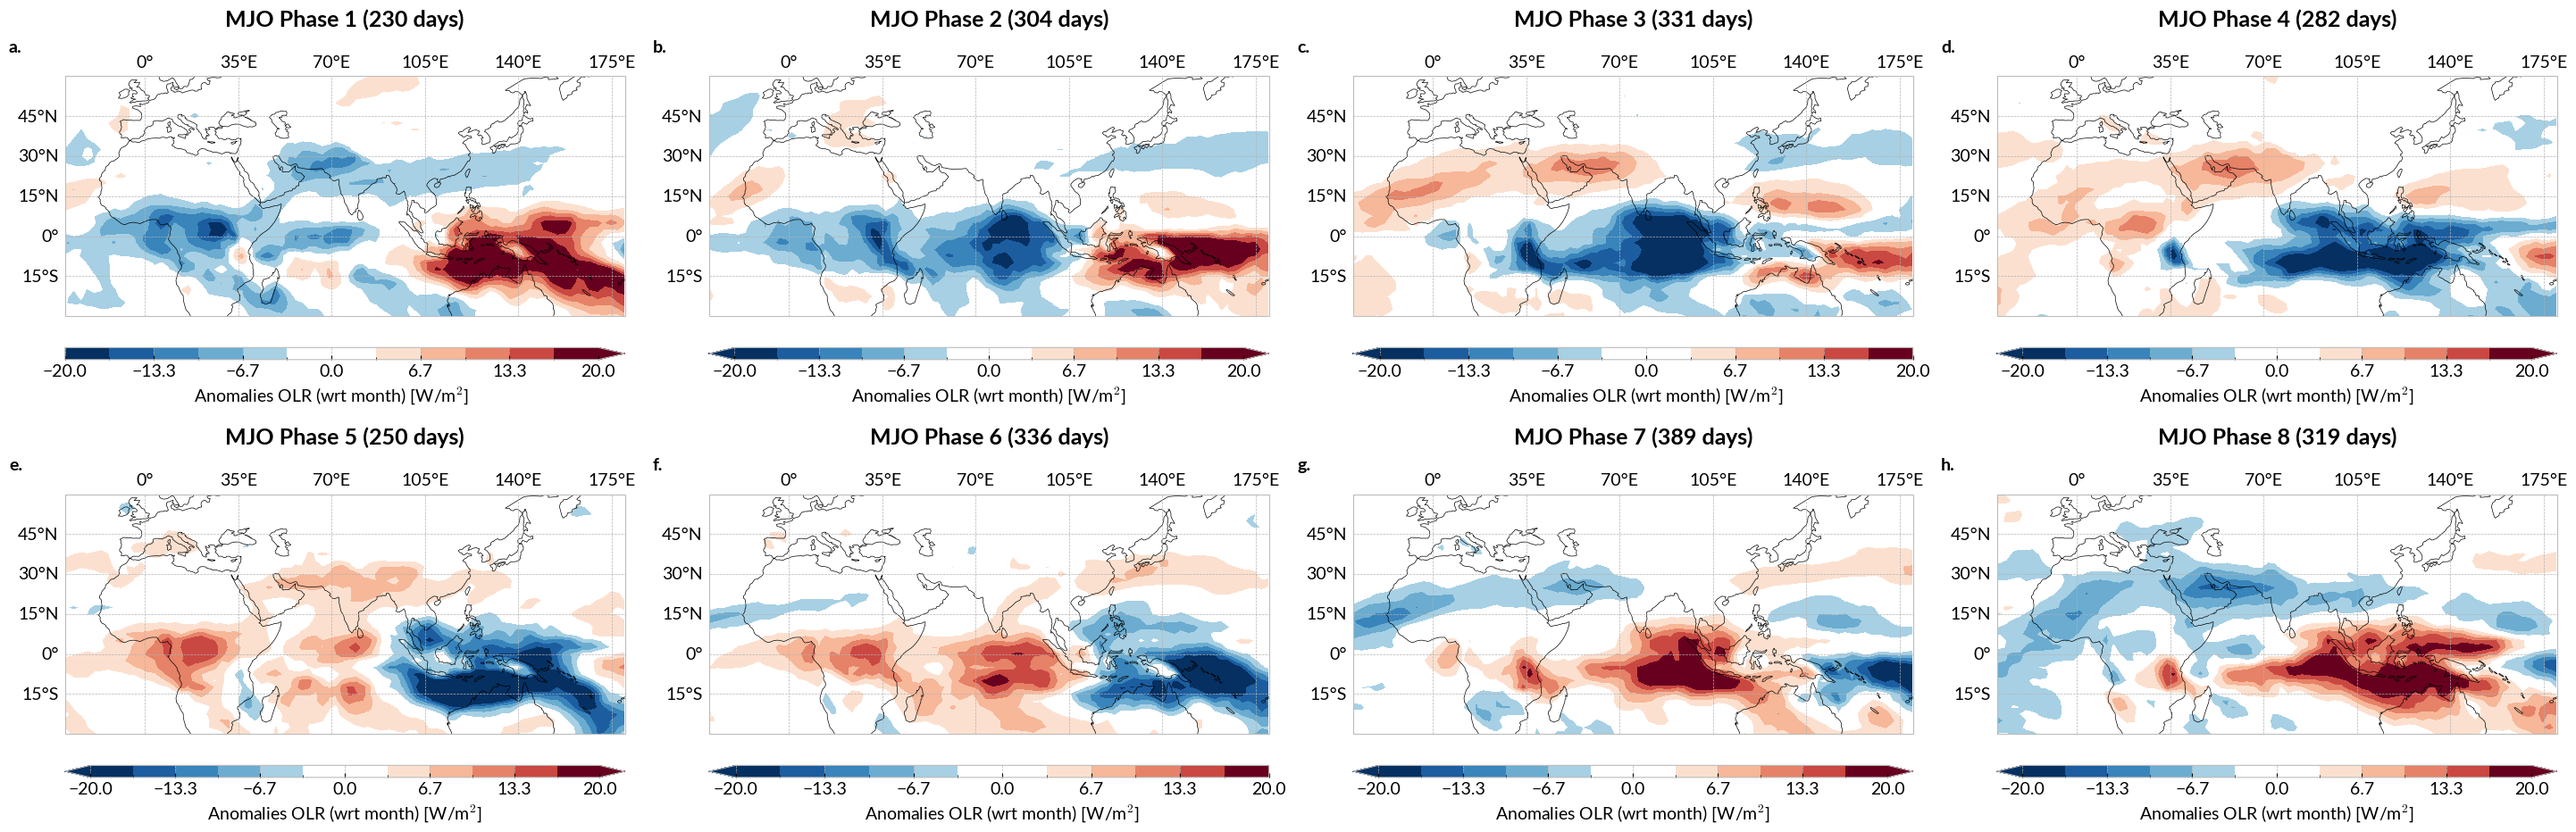

In [5]:
# Plot the OLR data for the Indo-Pacific region
reload(cplt)
reload(rmm)
nrows = 2
ncols = 4
im = cplt.create_multi_plot(nrows=nrows,
                            ncols=ncols,
                            projection='PlateCarree',
                            hspace=0.55, wspace=0.15,
                            orientation='horizontal',
                            lon_range=[-30, 180],
                            lat_range=[-30, 60])
an_type = 'month'
var_type = f'olr_an_{an_type}'
for idx, phase in enumerate(np.arange(1, 9)):
    tps = rmm.get_mjophase_tps(
        phase_number=phase,
        start_month='Jan',
        end_month='Mar',
        active=True)

    mean_pr, sig_pr = tu.get_mean_tps(da=ds_olr.ds[var_type],
                                      tps=tps,
                                        )

    an_type = 'month'

    vmax = 20
    vmin = -vmax

    im_comp = cplt.plot_map(mean_pr,
                            ax=im['ax'][idx],
                            plot_type='contourf',
                            cmap='RdBu_r',
                            centercolor='white',
                            levels=12,
                            vmin=vmin, vmax=vmax,
                            title=f"MJO Phase {phase} ({len(tps)} days)",
                            label=rf'Anomalies OLR (wrt {an_type}) [W/m$^2$]',
                            )

savepath = plot_dir + \
    f"definitions/mjo_phase_olr_{an_type}.png"
cplt.save_fig(savepath=savepath, fig=im['fig'])

In [6]:
# Now we compute the mean time series in the Indo-Pacific region [20°S, 20°N], [-180, 180]
da_olr = sput.cut_map(ds_olr.ds['olr_an_month'],
                      lon_range=[-180, 180],
                      lat_range=[-15, 15])
mean_ts = sput.compute_zonal_mean(sput.compute_meridional_mean(da_olr))
mean_ts

<xarray.DataArray (time: 14975)>
array([ 2.09616122,  2.56694963,  3.7051489 , ...,  1.01111162,
        0.36681373, -0.71199689])
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
    metpy_crs  object Projection: latitude_longitude
    month      (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365

In [32]:
reload(fta)
cutoff = 2
var_power = 'power'
fft_mjo_full = fta.compute_fft(ts=mean_ts,
                               window='blackman',
                               cutoff=cutoff)


fft_mjo = fta.fft_by_year(ts=mean_ts,
                          window='blackman',
                          cutoff=cutoff,
                          fft_prop=var_power,)


fft_surr = fta.ar1_surrogates_spectrum(ts=mean_ts,
                                       lags=2,
                                       N=10, cutoff=cutoff,
                                       fft_prop=var_power,
                                       )

100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


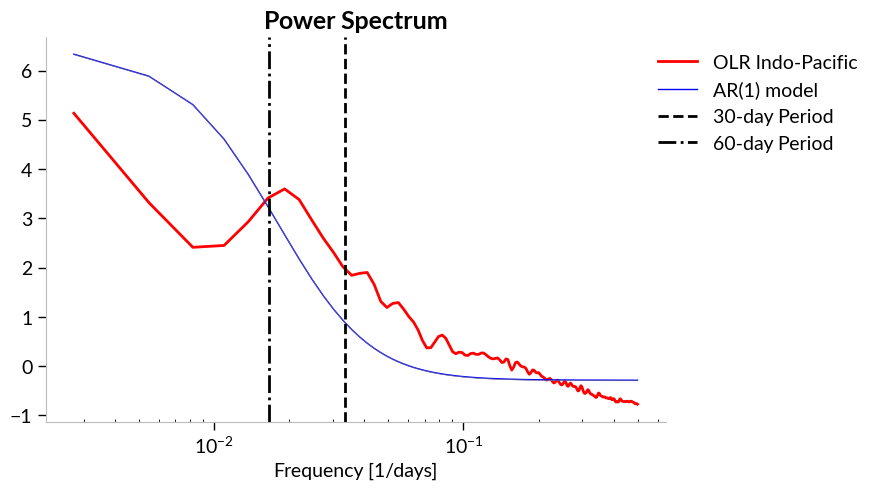

In [42]:
reload(cplt)
an_days = 365
freq = 122
jjas_freq = 1/(freq)
annual_freq = 1/an_days  # daily Freq / days per year
day_period_1 = 30
day_period_2 = 60
num_jjas = 122


im = cplt.plot_xy(
    x_arr=[fft_mjo['freq'],
           fft_surr['freq']],
    y_arr=[
        fft_mjo[var_power],
        fft_surr[f'{var_power}5']
    ],
    y_lb_arr=[None, fft_surr[f'{var_power}5']],
    y_ub_arr=[None, fft_surr[f'{var_power}95']],
    label_arr=['OLR Indo-Pacific',
               'AR(1) model'],
    title=f"Power Spectrum",
    color_arr=['red', 'blue', 'green', 'grey'],
    color_arr_ci='grey',
    lw_arr=[2, 1, 1, 1],
    ls_arr=['-', '-', '-', '--'],
    xlabel='Frequency [1/days]',
    ylabel=f'{var_power}' if idx % ncols == 0 else None,
    xlog=True,
    ylog=False,
    # xlim=(1e1, 1.5e2),
    # ylim=(0, 1),
    # xlim=(0,1),
    # ylim=(0, 1e1),
    stdize=True,
    set_legend=True,
)

im = cplt.plot_vline(
    ax=im['ax'], x=1./day_period_1,
    color='black',
    label=f"{day_period_1}-day Period",
    ls='dashed',
    lw=2)
im = cplt.plot_vline(
    ax=im['ax'], x=1./day_period_2,
    color='black',
    label=f"{day_period_2}-day Period",
    ls='dashdot',
    lw=2)

cplt.set_legend(ax=im['ax'], loc='outside')
savepath = plot_dir + \
    f"power_spectrum_olr.png"
cplt.save_fig(savepath=savepath)